Overall plan:
- Get sampled values from image
- Center image on source peak
- 5 arcsec x 5 arcsec
- Interpolate vertical and horizontal directions to "smooth" image
- Shove into SQL database
- Call this function in make_catalog

In [91]:
from astropy.coordinates import Angle
import astropy.units as u
from astropy.io import fits
from find_source import fits_data_index, summary, significant
import matplotlib.pyplot as plt
import numpy as np
import math

{'field_center': (0, 0),
 'rms_val': 0.013562027364969254,
 'mad': 0.008480636402964592,
 'sd_mad': 0.012503727036788906,
 'n_incl_meas': 17.874989667867982,
 'n_excl_meas': 401.3935903796145,
 'fwhm': 4.4968248,
 'incl_radius': 9.496824799999999,
 'neg_peak': -0.037036098539829254,
 'int_peak_val': [12.789649963378906],
 'int_peak_coord': [(-0.6042424478692535, -0.6042424478692535)],
 'int_prob': [0.0],
 'int_snr': [943.0485294856874],
 'ext_peak_val': 'No significant external peak',
 'ext_peak_coord': 'No significant external peak',
 'ext_prob': 'No significant external peak',
 'ext_snr': 'No significant external peak',
 'calc_rms_val': 0.03939359221066029,
 'neg_peak_rms_val': 0.013123339744160951,
 'calc_ext_prob': 6.966741067082865e-15,
 'calc_ext_snr': 2.80815391705438,
 'calc_int_prob': [0.0],
 'calc_int_snr': [974.5728002713246],
 'conservative_rms': 0.03939359221066029,
 'conservative_snr': 324.663}

<Figure size 384x288 with 0 Axes>

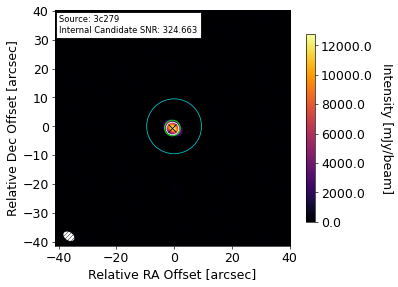

In [92]:
summary('../data/11151/3c279.fits')

arguments:
- peak coords (normalized)
- pixel scale
- x-axis length
- y-axis length
- fits file path

In [93]:
def interpolation_kernel(s):
    if abs(s) % 1 == 0:
        return 0
    if abs(s) < 1:
        return (3/2 * (s**3) - 5/2 * (s**2) + 1)
    if abs(s) < 2:
        return (-1/2 * (s**3) + 5/2 * (s**2) - 4 * s + 2)
    return 0

In [110]:
def interpolation_function(x, node_x, node_val):
    num_nodes = len(node_x)
    N = num_nodes - 1

    # make sure inputs are valid
    if len(node_val) != num_nodes:
        raise ValueError("The number of nodes given does not match the number of node values given")
    h = node_x[1] - node_x[0]
    for i in range(1, N):
        if node_x[i+1] - node_x[i] != h:
            raise ValueError("Nodes are not uniformly spaced")

    # boundary conditions
    node_neg1 = node_x[0] - h
    node_Nplus1 = node_x[N] + h
    c_neg1 = node_val[2] - 3*node_val[1] + 3*node_val[0]
    c_Nplus1 = 3*node_val[N] - 3*node_val[N-1] + 3*node_val[N-2]

    # apply interpolation function
    interpolated_val = c_neg1 * interpolation_kernel((x - node_neg1) / h)
    for k in range(0, num_nodes):
        s = (x - node_x[k]) / h
        interpolated_val += node_val[k] * interpolation_kernel(s)
    interpolated_val += c_Nplus1 * interpolation_kernel((x - node_Nplus1) / h)
    return float(interpolated_val)

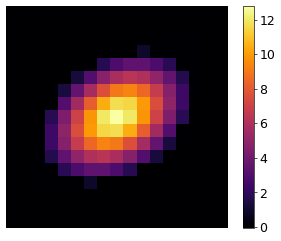

In [111]:
fits_file = '../data/11151/3c279.fits' # change this to actual path for testing

##### BELOW IS COPIED FROM region_stats #####
i = fits_data_index(fits_file)

# open FITS file
try:
    file = fits.open(fits_file)
except:
    print(f'Unable to open {fits_file}')

# extract data array
info = file[i]
data = info.data

##### STARTING NEW-ISH STUFF #####
data_array = data[0]
min_flux = np.min(data_array)
max_flux = np.max(data_array)

header_data = fits.getheader(fits_file)

beam_maj = Angle(header_data['BMAJ'], header_data['CUNIT1']).to_value('arcsec')
pixel_scale = Angle(header_data['CDELT1'], header_data['CUNIT1']).to_value('arcsec')
x_dim = header_data['NAXIS1']
y_dim = header_data['NAXIS2']

center = (round(x_dim/2), round(y_dim/2))

##### MADE THIS UP FOR TESTING PURPOSES #####
peak_coords = (-0.6042424478692535, -0.6042424478692535) # normalized peak coordinates, will be an argument

##### CONTINUING MY CODE #####
# unnormalized the normalized coordinates
unnorm_x = round((peak_coords[0] / pixel_scale) + center[0])
unnorm_y = round((peak_coords[1] / pixel_scale) + center[1])

delta = math.ceil((2.5 + (beam_maj/2))/ pixel_scale) # ~number pixels in search radius

# make sure the ~5x5 arcsec box is actually inside the original image and handle issues if not
new_data = data_array
if unnorm_y - delta >= 0:
    new_data = data_array[unnorm_y - delta:]
if unnorm_y + delta < y_dim:
    new_data = new_data[:(unnorm_y + delta) - y_dim + 1]
if unnorm_x - delta >= 0:
    new_data = [row[unnorm_x - delta:] for row in new_data]
if unnorm_x + delta < x_dim:
    new_data = [row[:(unnorm_x + delta) - x_dim + 1] for row in new_data]

y_length = len(new_data)
if y_length == 0:
    raise ValueError("Attempts to obtain a smaller image centered on the source resulted in an empty data array.")
else:
    x_length = len(new_data[0])

# plotting image
fig, ax = plt.subplots()
plt.axis('off')
img = ax.imshow(new_data, vmin=min_flux, vmax=max_flux)
fig.colorbar(img)

IMPORTANT: data[y][x]

In [ ]:
node_x = np.arange(0, x_length).tolist()
node_y = np.arange(0, y_length).tolist()

interpolated_data = []

# first interpolate in x direction (add entries to rows)
pts_bw_nodes = 3
pts_spacing = 1 / (pts_bw_nodes + 1)

# iterate through rows
for row_num in range(y_length):
    temp = new_data[row_num].tolist()

    # iterate through nodes in row
    for i in range(x_length - 1):
        temp2 = []
        for j in range(1, pts_bw_nodes+1):
            x = i + j*pts_spacing
            temp2.append(interpolation_function(x, node_x=node_x, node_val=new_data[row_num]))
        temp = temp[:i-x_length+1] + temp2 + temp[i-x_length+1:]

    interpolated_data.append(temp)

# interpolate in y direction (add rows)


In [117]:
interpolated_data

[[0.0020724651403725147,
  0.1067483052611351,
  0.08781614154577255,
  0.07011348754167557,
  0.0035101750399917364,
  0.1233612447977066,
  0.10292124003171921,
  0.08297718316316605,
  0.0056211575865745544,
  0.08407387137413025,
  0.07245709747076035,
  0.059543900191783905,
  0.006532070692628622,
  -0.025711756199598312,
  -0.016705602407455444,
  -0.011184928938746452,
  0.004459742922335863,
  -0.19176854193210602,
  -0.15384051203727722,
  -0.12107547372579575,
  -0.0013625973369926214,
  -0.3737261891365051,
  -0.30609452724456787,
  -0.2439986765384674,
  -0.01016720850020647,
  -0.519157350063324,
  -0.4298602342605591,
  -0.3448391258716583,
  -0.01979709416627884,
  -0.5832206010818481,
  -0.4870810806751251,
  -0.39261505007743835,
  -0.02746216394007206,
  -0.5455141067504883,
  -0.4595622718334198,
  -0.37213581800460815,
  -0.03078736551105976,
  -0.4172029197216034,
  -0.35538309812545776,
  -0.2893809676170349,
  -0.02870723232626915,
  -0.2358020842075348,
  -0.20